In [ ]:


import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['CUDA_LAUNCH_BLOCKING']='1'

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch.nn.utils.rnn import pad_sequence
from typing import List, Tuple, Dict, Any, Union

# ds = load_dataset("stanfordnlp/imdb")

# imdb_dataset = load_dataset("stanfordnlp/imdb")


# train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
# test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")


tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


# def collate_fn(batch):
#   max_len = 400
#   texts, labels = [], []
#   for row in batch:
#     labels.append(row['label'])
#     texts.append(row['text'])

#   texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
#   labels = torch.LongTensor(labels)

#   return texts, labels

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    
     # 라벨이라 토큰화 안해도 됨
    labels.append(row['label'])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids))
  # 패딩을 옵션 안주고 따로
  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels



# train_loader = DataLoader(
#     train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
# )
# test_loader = DataLoader(
#     test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
# )

```python
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    
     # 라벨이라 토큰화 안해도 됨
    labels.append(row['label'])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
 
  
```

In [139]:
# 데이터셋 다시 불러오기 (전체 데이터셋 사용)
from datasets import load_dataset, concatenate_datasets

# 전체 데이터셋 로드
imdb_dataset = load_dataset("stanfordnlp/imdb")

# 데이터셋 확인
print("데이터셋 구조:", imdb_dataset)

# 훈련 데이터셋에서 긍정/부정 샘플 균등하게 추출
train_neg = imdb_dataset['train'].filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(625))
train_pos = imdb_dataset['train'].filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(625))
train_ds = concatenate_datasets([train_neg, train_pos]).shuffle(seed=42)

# 테스트 데이터셋에서 긍정/부정 샘플 균등하게 추출
test_neg = imdb_dataset['test'].filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(625))
test_pos = imdb_dataset['test'].filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(625))
test_ds = concatenate_datasets([test_neg, test_pos]).shuffle(seed=42)

# 데이터셋 크기 및 구성 확인
print("훈련 데이터셋 크기:", len(train_ds))
print("테스트 데이터셋 크기:", len(test_ds))

# 라벨 분포 확인
train_labels = [sample['label'] for sample in train_ds]
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

test_labels = [sample['label'] for sample in test_ds]
test_label_counts = pd.Series(test_labels).value_counts().sort_index()

print("\n=== 훈련 데이터셋 라벨 분포 ===")
for label, count in train_label_counts.items():
    percentage = count / len(train_ds) * 100
    print(f"라벨 {label} ({'부정적' if label == 0 else '긍정적'}): {count}개 ({percentage:.2f}%)")

print("\n=== 테스트 데이터셋 라벨 분포 ===")
for label, count in test_label_counts.items():
    percentage = count / len(test_ds) * 100
    print(f"라벨 {label} ({'부정적' if label == 0 else '긍정적'}): {count}개 ({percentage:.2f}%)")

batch_size = 128

# 데이터로더 재정의
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

데이터셋 구조: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
훈련 데이터셋 크기: 1250
테스트 데이터셋 크기: 1250

=== 훈련 데이터셋 라벨 분포 ===
라벨 0 (부정적): 625개 (50.00%)
라벨 1 (긍정적): 625개 (50.00%)

=== 테스트 데이터셋 라벨 분포 ===
라벨 0 (부정적): 625개 (50.00%)
라벨 1 (긍정적): 625개 (50.00%)


=== 훈련 데이터셋 라벨 분포 ===
라벨 0 (부정적): 625개 (50.00%)
라벨 1 (긍정적): 625개 (50.00%)

=== 테스트 데이터셋 라벨 분포 ===
라벨 0 (부정적): 625개 (50.00%)
라벨 1 (긍정적): 625개 (50.00%)


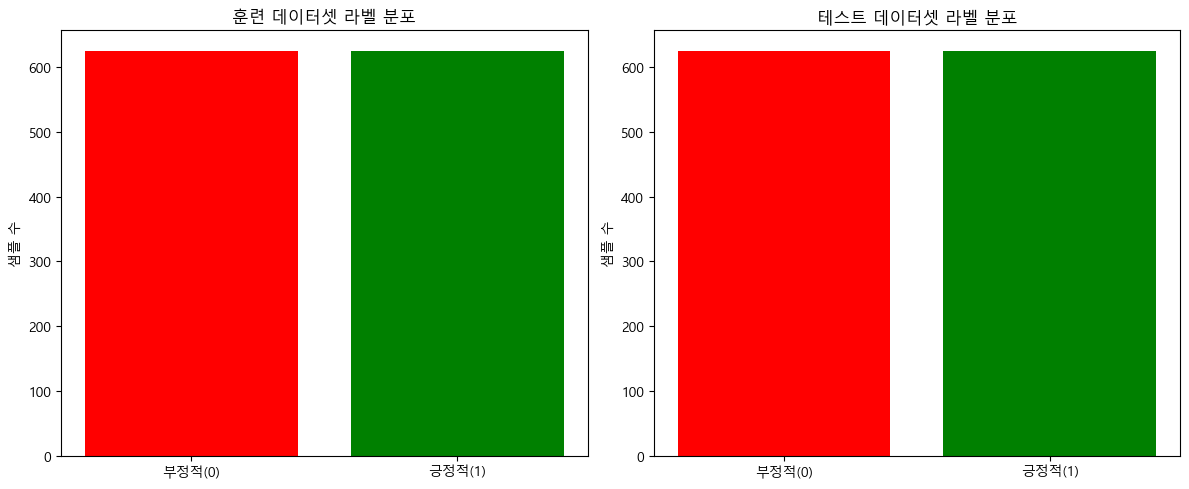

In [140]:
# 훈련 데이터셋과 테스트 데이터셋의 라벨 분포 확인
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 훈련 데이터셋 라벨 분포
train_labels = [sample['label'] for sample in train_ds]
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# 테스트 데이터셋 라벨 분포
test_labels = [sample['label'] for sample in test_ds]
test_label_counts = pd.Series(test_labels).value_counts().sort_index()

# 결과 출력
print("=== 훈련 데이터셋 라벨 분포 ===")
for label, count in train_label_counts.items():
    percentage = count / len(train_ds) * 100
    print(f"라벨 {label} ({'부정적' if label == 0 else '긍정적'}): {count}개 ({percentage:.2f}%)")

print("\n=== 테스트 데이터셋 라벨 분포 ===")
for label, count in test_label_counts.items():
    percentage = count / len(test_ds) * 100
    print(f"라벨 {label} ({'부정적' if label == 0 else '긍정적'}): {count}개 ({percentage:.2f}%)")

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(['부정적(0)', '긍정적(1)'], train_label_counts.values, color=['red', 'green'])
plt.title('훈련 데이터셋 라벨 분포')
plt.ylabel('샘플 수')

plt.subplot(1, 2, 2)
plt.bar(['부정적(0)', '긍정적(1)'], test_label_counts.values, color=['red', 'green'])
plt.title('테스트 데이터셋 라벨 분포')
plt.ylabel('샘플 수')

plt.tight_layout()
plt.show()

 다차원 텐서의 행렬 곱셈을 수행할 때, 마지막 두 차원 간에 행렬 곱셈을 수행한다

In [141]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    # 
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    B, S, D = q.shape[0], q.shape[1], self.d_model // self.n_heads



    q = q.reshape((B, S, self.n_heads, D)).transpose(1, 2) # B, H(n), S, D
    k = k.reshape((B, S, self.n_heads, D)).transpose(1, 2)
    v = v.reshape((B, S, self.n_heads, D)).transpose(1, 2)

    # A 계산
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, H, S, D) * (B, H, D, S) = (B, H, S, S)
    
    # D' = d_model / n_heads
    
    #이거 써야 하는거 아닌가 > 이렇게 하면 
    score = score / sqrt(D) 
    # score = score / sqrt(self.d_model)
    
    #  

    if mask is not None:
      score = score + (mask[:, None] * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)  # (B, H, S, D)

    result = result.transpose(1, 2).reshape((B, S, -1))
    result = self.dense(result)

    return result

d_model 은 신경망 차원 길이라는 것을 항상 유념

In [142]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, n_heads, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads
    self.dff = dff

    self.sa = MultiHeadAttention(input_dim, d_model, n_heads)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    self.norm1 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(0.1)

    self.norm2 = nn.LayerNorm(d_model)
    self.dropout2 = nn.Dropout(0.1)

  def forward(self, x, mask):
    x1 = self.sa(x, mask)
    x1 = self.dropout1(x1)
    x1 = self.norm1(x + x1)

    x2 = self.ffn(x1)
    x2 = self.dropout2(x2)
    x2 = self.norm2(x1 + x2)

    return x2

In [143]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


최종 output 클래스 크기 2 ( 긍정 , 부정 ) 으로 분류

In [144]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_heads, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_heads = n_heads
    self.n_layers = n_layers


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 2)

  def forward(self, x):
    seq_len = x.shape[1]
    mask = (x == tokenizer.pad_token_id)[..., None] # (B, S, 1)

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x



# vocab_size, d_model, n_heads, n_layers, dff
model = TextClassifier(len(tokenizer), 32, 4, 5, 32)

In [145]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [146]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
import platform

# 운영체제별 기본 폰트 설정
if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'  # 윈도우의 경우 맑은 고딕
elif platform.system() == 'Darwin':  # Mac OS
    font_name = 'AppleGothic'
else:  # Linux 등 기타 OS
    font_name = 'NanumGothic'  # 나눔고딕

# 폰트 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [147]:


def accuracy(model, dataloader):
  cnt = 0
  acc = 0
  pos_correct = 0  # 긍정 예측 정확도
  neg_correct = 0  # 부정 예측 정확도
  pos_total = 0    # 실제 긍정 샘플 수
  neg_total = 0    # 실제 부정 샘플 수

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()
    
    # 긍정(1)과 부정(0) 정확도 별도 계산
    pos_mask = (labels == 1)
    neg_mask = (labels == 0)
    
    pos_total += pos_mask.sum().item()
    neg_total += neg_mask.sum().item()
    
    pos_correct += ((preds == 1) & pos_mask).sum().item()
    neg_correct += ((preds == 0) & neg_mask).sum().item()

  pos_acc = pos_correct / pos_total if pos_total > 0 else 0
  neg_acc = neg_correct / neg_total if neg_total > 0 else 0
  
  return {
    "전체_정확도": acc / cnt,
    "긍정_정확도": pos_acc,
    "부정_정확도": neg_acc
  }


In [148]:
n_epochs = 30


train_acc_history = []
test_acc_history = []
pos_acc_history = []
neg_acc_history = []


for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_metrics = accuracy(model, train_loader)
    test_metrics = accuracy(model, test_loader)
    train_acc = train_metrics['전체_정확도']
    test_acc = test_metrics['전체_정확도']
    # 결과 저장
    train_acc_history.append(train_metrics['전체_정확도'])
    test_acc_history.append(test_metrics['전체_정확도'])
    pos_acc_history.append(test_metrics['긍정_정확도'])
    neg_acc_history.append(test_metrics['부정_정확도'])
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 7.12120795249939
=========> Train acc: 0.501 | Test acc: 0.502
Epoch   1 | Train Loss: 6.907056212425232
=========> Train acc: 0.597 | Test acc: 0.557
Epoch   2 | Train Loss: 6.631411910057068
=========> Train acc: 0.653 | Test acc: 0.573
Epoch   3 | Train Loss: 6.367724180221558
=========> Train acc: 0.679 | Test acc: 0.611
Epoch   4 | Train Loss: 6.041150450706482
=========> Train acc: 0.711 | Test acc: 0.622
Epoch   5 | Train Loss: 5.815653860569
=========> Train acc: 0.709 | Test acc: 0.602
Epoch   6 | Train Loss: 5.562056720256805
=========> Train acc: 0.774 | Test acc: 0.630
Epoch   7 | Train Loss: 5.168065816164017
=========> Train acc: 0.786 | Test acc: 0.638
Epoch   8 | Train Loss: 4.856381982564926
=========> Train acc: 0.795 | Test acc: 0.626
Epoch   9 | Train Loss: 4.369020044803619
=========> Train acc: 0.844 | Test acc: 0.632
Epoch  10 | Train Loss: 3.7477887570858
=========> Train acc: 0.859 | Test acc: 0.615
Epoch  11 | Train Loss: 3.420351758599

In [149]:

sample_length = n_epochs

def plot_sentiment_results(train_acc_history, test_acc_history, pos_acc_history, neg_acc_history):
  from IPython import display  # display 모듈 임포트 추가
  
  plt.figure(figsize=(15, sample_length))
  
  # 1. 정확도 그래프
  plt.subplot(2, 2, 1)
  plt.plot(train_acc_history, label='훈련 정확도')
  plt.plot(test_acc_history, label='테스트 정확도')
  plt.title('학습 과정의 정확도 변화')
  plt.xlabel('에폭')
  plt.ylabel('정확도')
  plt.legend()
  plt.grid(True)
  
  # 2. 빈 공간을 활용한 새 그래프 (또는 삭제해도 됨)
  plt.subplot(2, 2, 2)
  plt.plot(train_acc_history[-sample_length], label='최근 훈련 정확도')
  plt.plot(test_acc_history[-sample_length], label='최근 테스트 정확도')
  plt.title('최근 10개 에폭의 정확도')
  plt.xlabel('에폭')
  plt.ylabel('정확도')
  plt.legend()
  plt.grid(True)
  
  # 3. 긍정/부정 정확도 그래프
  plt.subplot(2, 2, 3)
  plt.plot(pos_acc_history, label='긍정 정확도', color='green')
  plt.plot(neg_acc_history, label='부정 정확도', color='orange')
  plt.title('긍정/부정 정확도 변화')
  plt.xlabel('에폭')
  plt.ylabel('정확도')
  plt.legend()
  plt.grid(True)
  
  # 4. 최신 결과 막대 그래프
  plt.subplot(2, 2, 4)
  metrics = ['전체', '긍정', '부정']
  # test_metrics 변수 대신 마지막 요소 사용
  values = [test_acc_history[-1], pos_acc_history[-1], neg_acc_history[-1]]
  colors = ['blue', 'green', 'orange']
  plt.bar(metrics, values, color=colors)

  plt.ylim(0, 1)
  for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
  plt.title('최신 테스트 결과')
  
  plt.tight_layout()
  display.clear_output(wait=True)
  display.display(plt.gcf())
  
  return plt.gcf()  # 그래프 객체 반환
# ... existing code ...

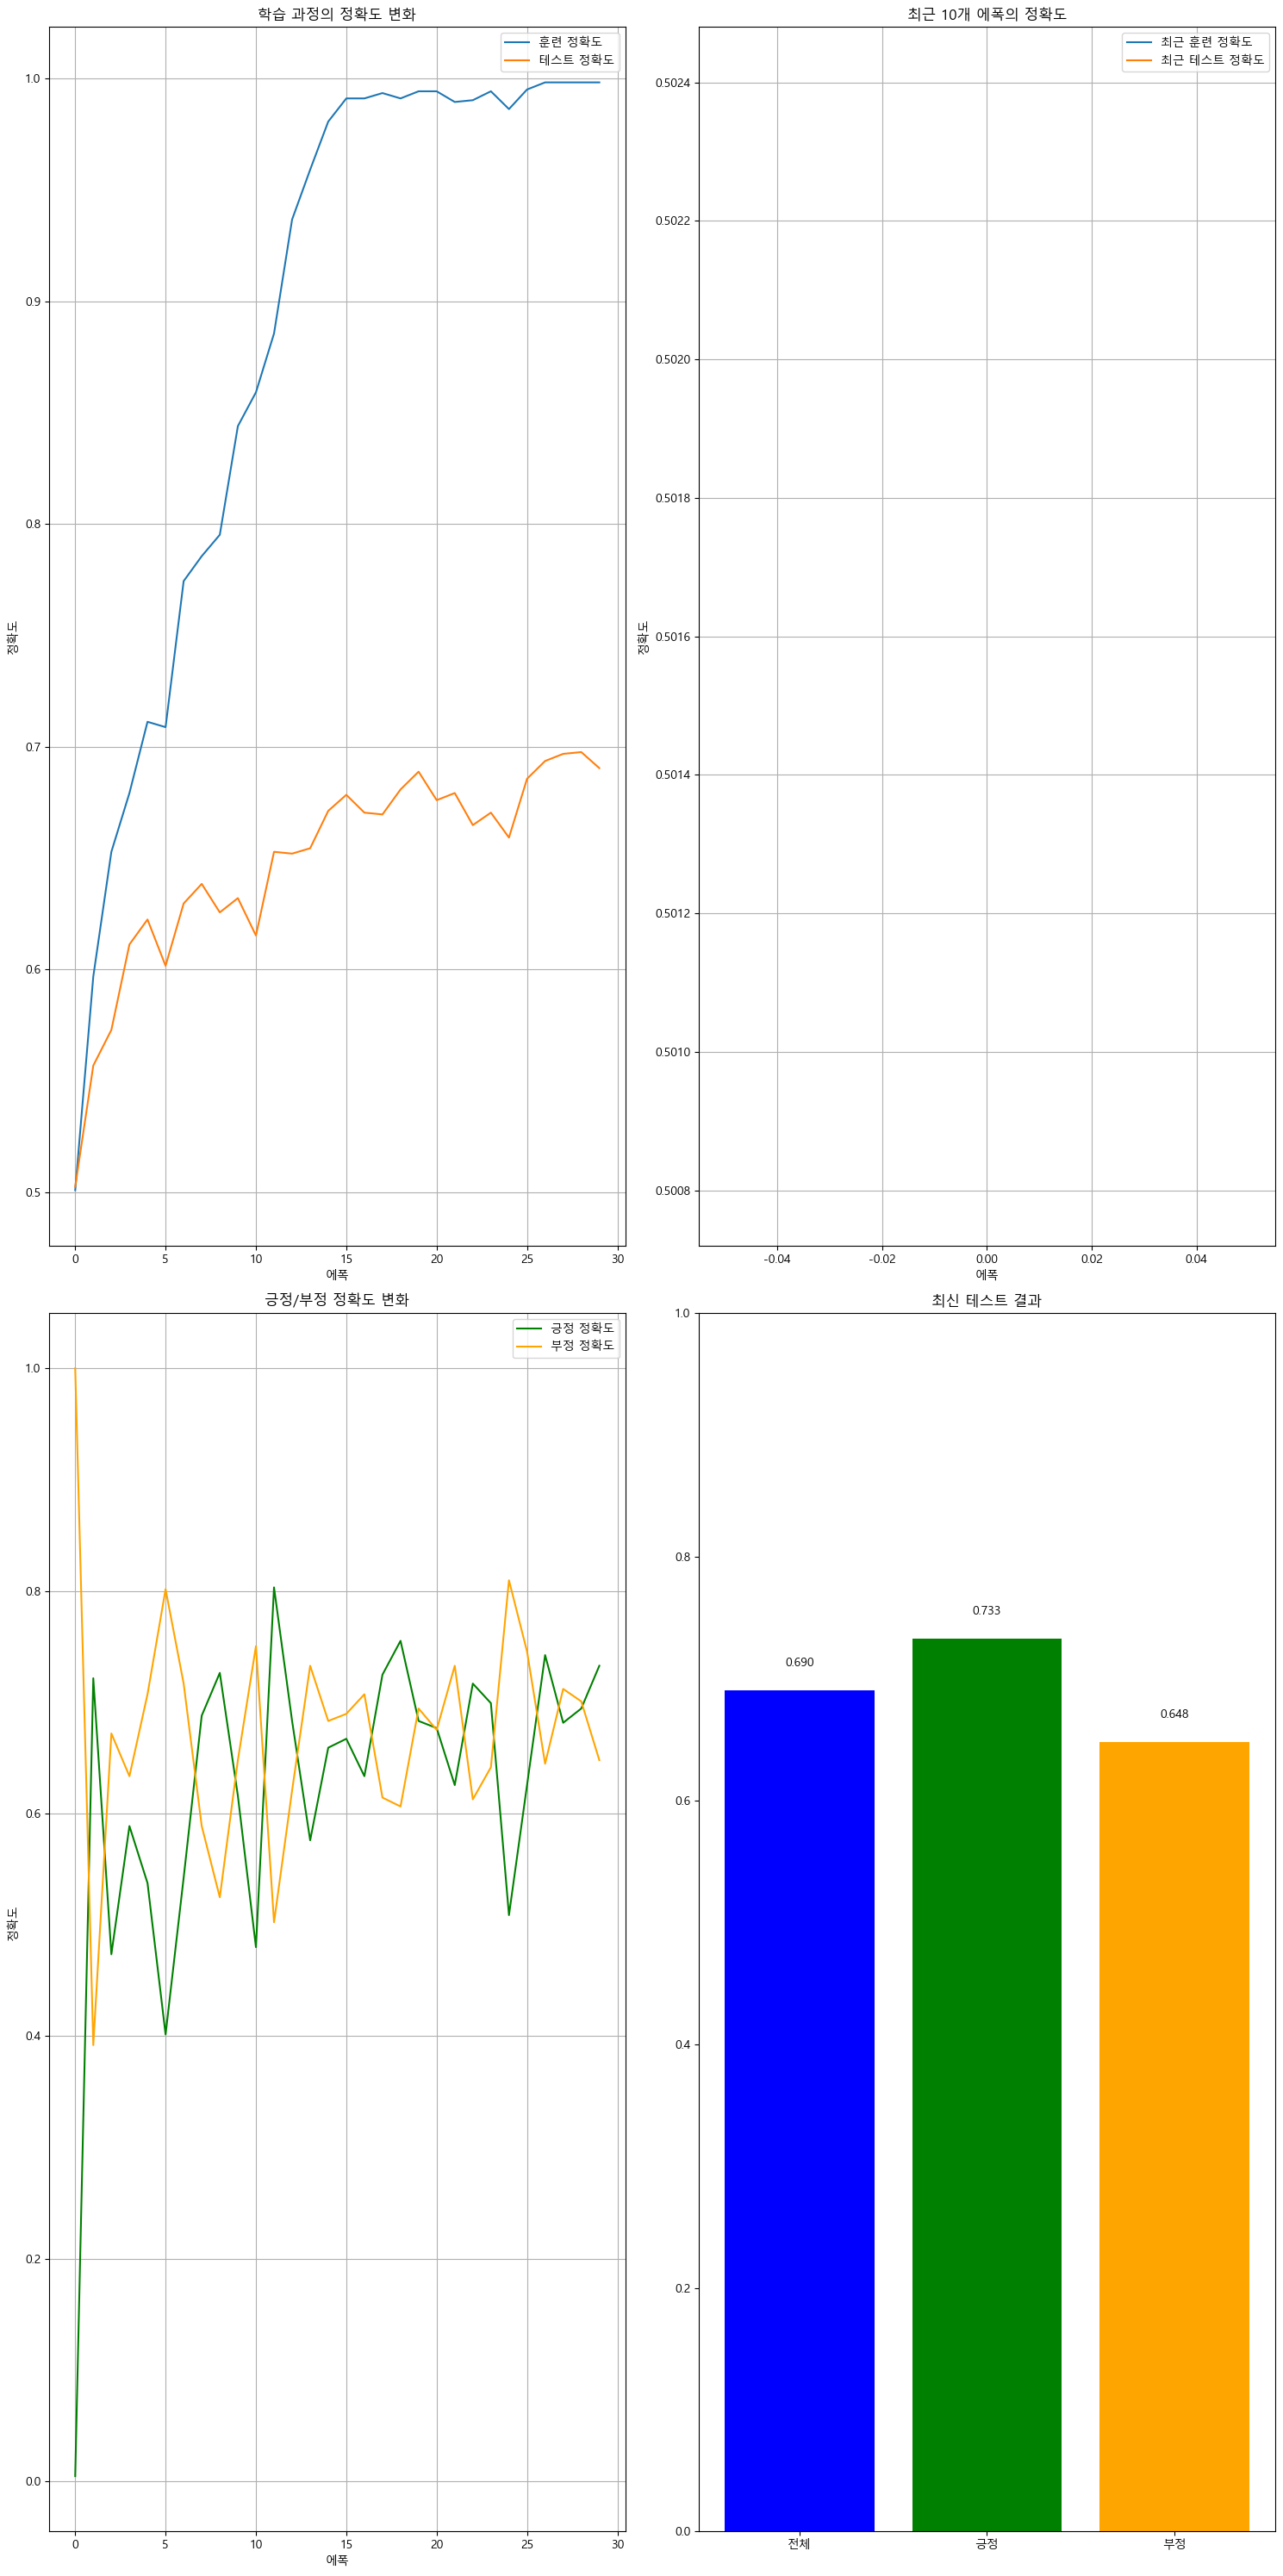

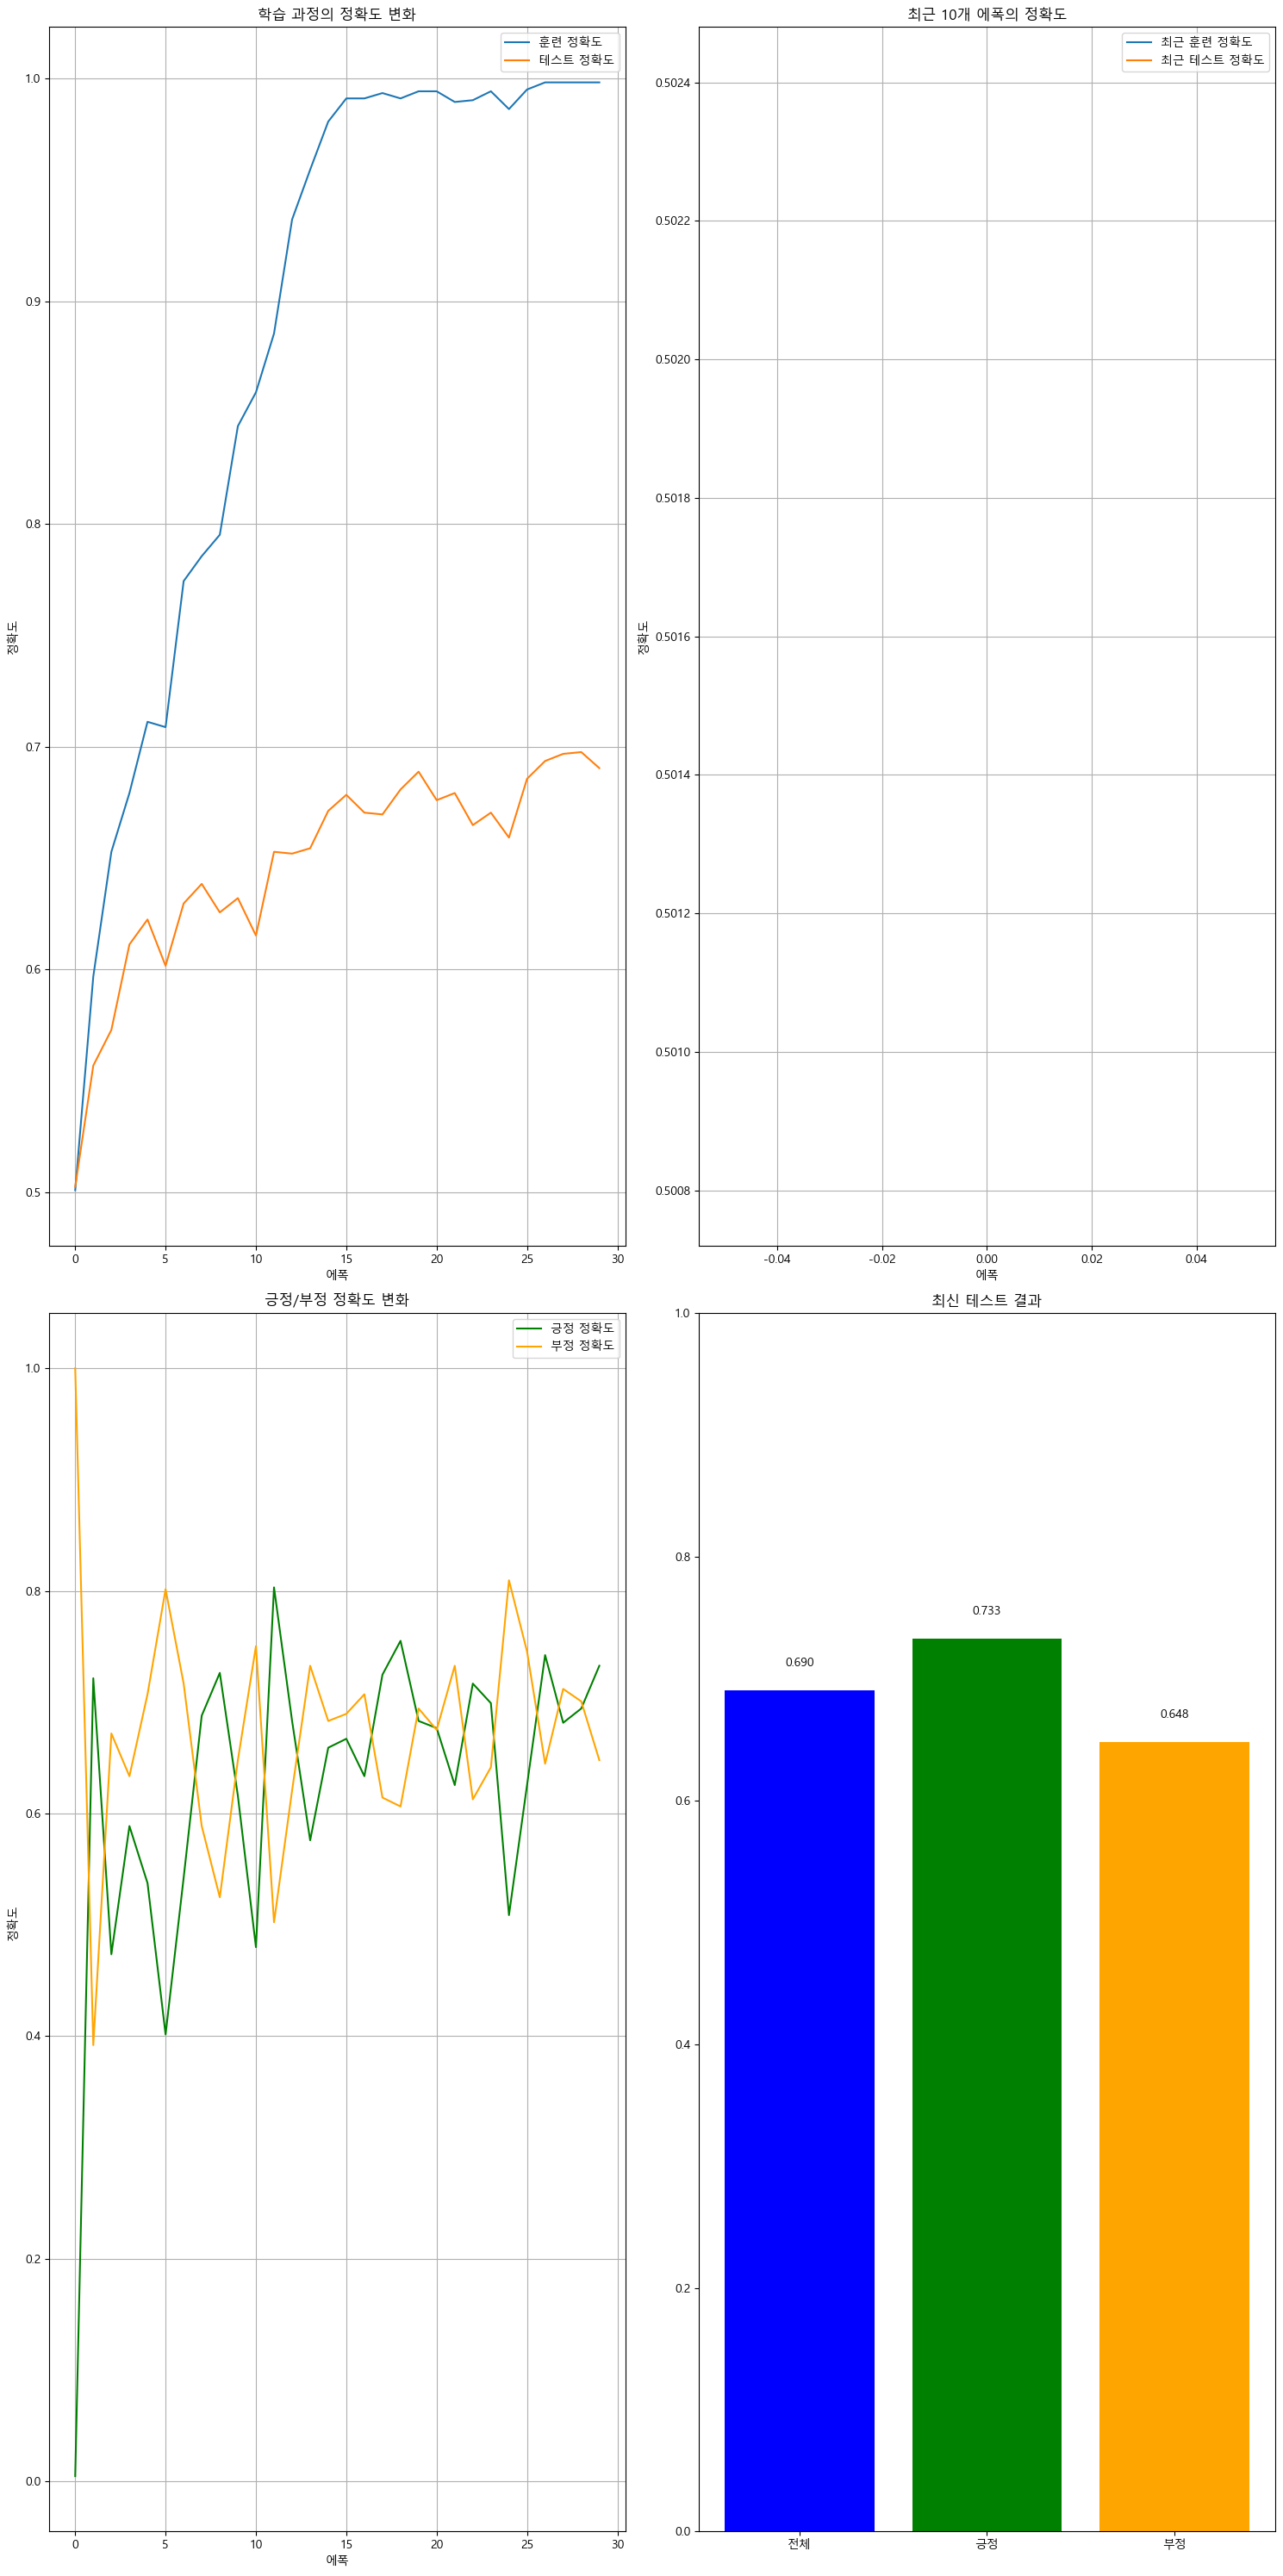

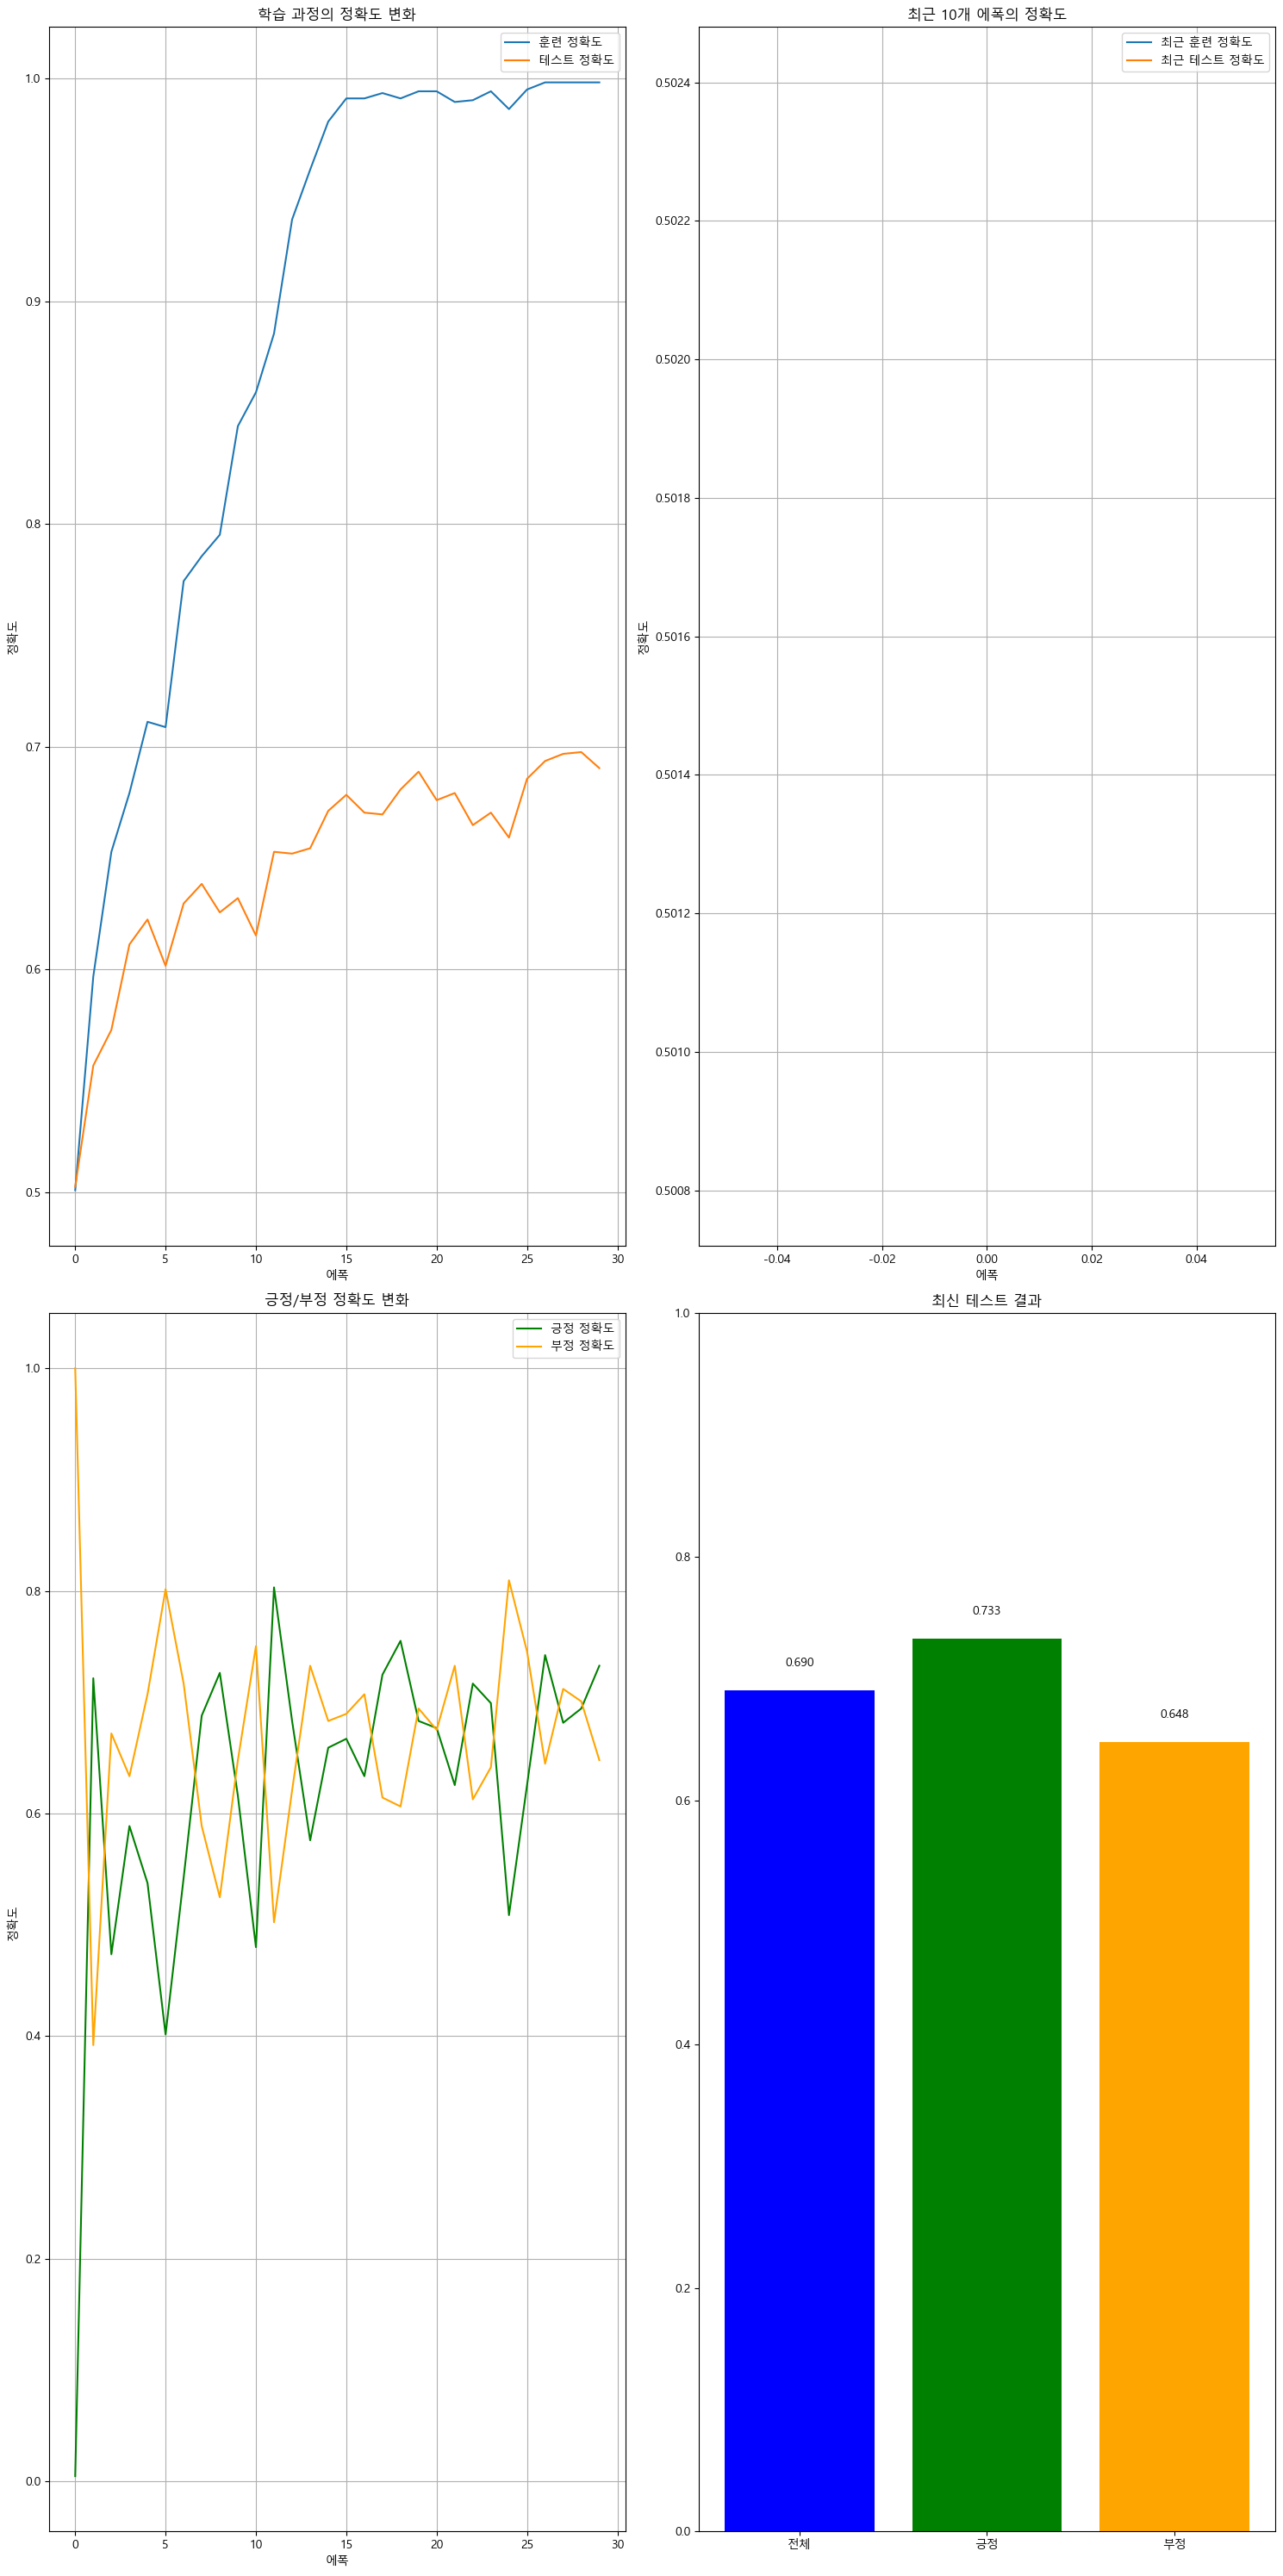

In [150]:
plot_sentiment_results(train_acc_history, test_acc_history, pos_acc_history, neg_acc_history)
  

In [151]:
import random
import torch

def 랜덤_샘플_테스트():
    # 랜덤 시드 설정 (재현성을 위해)
    # random.seed(42)
    
    # 테스트 데이터에서 랜덤 샘플 선택
    랜덤_인덱스 = random.randint(0, len(test_ds) - 1)
    샘플 = test_ds[랜덤_인덱스]
    
    # 원본 텍스트
    원본_텍스트 = 샘플['text']
    
    # 토큰화 및 모델 입력 준비
    토큰화_입력 = tokenizer(원본_텍스트, truncation=True, max_length=400, return_tensors='pt')
    입력 = 토큰화_입력['input_ids'].to('cuda')
    
    # 예측 수행
    model.eval()
    with torch.no_grad():
        출력값 = model(입력)
        예측_클래스 = torch.argmax(출력값, dim=-1).item()
        확률 = torch.softmax(출력값, dim=-1)[0][예측_클래스].item()
    
    # 실제 라벨
    실제_라벨 = 샘플['label']
    
    # 출력 포맷팅
    감정_라벨 = {0: "부정적(Negative)", 1: "긍정적(Positive)"}
    예측_감정 = 감정_라벨[예측_클래스]
    실제_감정 = 감정_라벨[실제_라벨]
    
    # 결과 출력
    print(f"## 원문 텍스트 (앞부분 200자):")
    print(f"{원본_텍스트[:200]}...")
    print("\n" + "="*50 + "\n")
    
    print(f"## 예측 결과:")
    print(f"예측 감정: {예측_감정} (확률: {확률:.2%})")
    print(f"실제 정답: {실제_감정}")
    
    # 예측이 맞았는지 여부
    if 예측_클래스 == 실제_라벨:
        print("✓ 예측 성공!")
    else:
        print("✗ 예측 실패!")
    
    return 원본_텍스트, 예측_감정, 실제_감정, 확률

# 함수 실행
원본, 예측, 정답, 확률 = 랜덤_샘플_테스트()

## 원문 텍스트 (앞부분 200자):
This movie had the potential to be a decent thriller, but it was hampered by only having about twenty minutes worth of good script, which was mostly used up in the beginning. After that holes started ...


## 예측 결과:
예측 감정: 부정적(Negative) (확률: 99.76%)
실제 정답: 부정적(Negative)
✓ 예측 성공!
